In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats

In [3]:
url = 'https://www.quandl.com/api/v3/datasets/BCHARTS/BTCCUSD.csv?api_key=dRQvv5_zYkkwzDssiLzH'

data = pd.read_csv(new_file)
data.index = data['Date']
del data['Date']
del data.index.name
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
2017-08-12,3600.00,4049.99,3600.0,3850.0,45.2332,170441.955545,3768.072026
2017-08-11,3385.00,3692.00,3385.0,3620.0,94.2659,332785.519453,3530.285283
2017-08-10,3345.01,3470.00,3337.0,3442.9,40.7009,138241.567918,3396.523613
2017-08-09,3417.00,3505.00,3242.0,3365.0,108.1564,367182.606553,3394.922599
2017-08-08,3399.97,3498.50,3350.0,3420.0,111.3431,381639.838445,3427.602056


In [2]:
new_file = '../storage/crypto.csv'
columns = ['id','timestamp', 'currency_from', 'currency_to', 'High', 'Low', 'open', 'Close', 'volume', 'quote_volume', 'weighted_ave'] 

def import_data(url, names):
    data = pd.read_csv(url, names=names)
    data.index = pd.to_datetime(data['timestamp'], unit='s')
    del data['timestamp']
    del data.index.name
    return data

data = import_data(new_file, columns)
data = data.iloc[0:401]
data.tail()

,id,currency_from,currency_to,High,Low,open,Close,volume,quote_volume,weighted_ave
2017-08-07 11:50:00,397,ETH,BTC,0.080454,0.080205,0.080400,0.080285,31.120054,387.480305,0.080314
2017-08-07 11:55:00,398,ETH,BTC,0.080705,0.080285,0.080300,0.080460,48.821253,606.347698,0.080517
2017-08-07 12:00:00,399,ETH,BTC,0.080511,0.080267,0.080460,0.080452,44.053121,547.642998,0.080441
2017-08-07 12:05:00,400,ETH,BTC,0.080500,0.080000,0.080452,0.080325,167.578970,2090.815591,0.080150
2017-08-07 12:10:00,401,ETH,BTC,0.080489,0.080000,0.080000,0.080471,141.633733,1768.629112,0.080081


In [4]:
data = data.reindex(index=data.index[::-1])
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
2017-04-12,1239.9,1239.9,1223.00,1230.0,89.4465,109903.068650,1228.701723
2017-04-13,1230.0,1233.9,1160.02,1183.0,370.4015,441422.023361,1191.739297
2017-04-14,1183.0,1218.0,1181.00,1207.0,129.5010,155690.996409,1202.237793
2017-04-15,1206.0,1215.0,1191.85,1192.0,159.5226,192173.690196,1204.680028
2017-04-16,1192.0,1213.0,1192.00,1213.0,74.9311,90195.815850,1203.716692


## Ichimoku Cloud Testing
  
  Lines Needed:  
  1) Conversion Line = (9-period high + 9-period low)/2))  
  2) Base Line = (26-period high + 26-period low)/2))  
  3) Leading Span A = (Conversion Line + Base Line)/2))  [midpoint of the conversion line and base line]  
  4) Leading Span B = (52-period high + 52-period low)/2))  
  5) Lagging Span = Close plotted 26 days in the past but on the current day

In [3]:
# Conversion Line

def find_rolling_highs_and_lows_line(high_data, low_data, window):
    '''
    Can be used to find conversion line or base line depending on the window size
    
    Inputs:
    high_data: pandas column from dataframe
    low_data: pandas column from dataframe
    window: int, window size
    
    Returns:
    line: 
    '''
    
    high = high_data.rolling(window=window).max()
    low = low_data.rolling(window=window).min()
    line = (high + low)/2
    return line.to_frame()

def find_span_B(high_data, low_data, window):
    #high = high_data.rolling(window=window).max()
    #low = low_data.rolling(window=window).min()
    #span_B = ((high + low)/2).shift(25, freq='min')
    span_B = find_rolling_highs_and_lows_line(high_data, low_data, window).shift(25, freq='min')
    return span_B

def find_span_A(conversion, base):
    span_A = ((conversion['Conversion'] + base['Base'])/2).shift(25, freq='min')
    return span_A.to_frame()

def find_ichimoku(data, convert_window, base_window, span_B_window, lagging_shift):
    high_data = data['High']
    low_data = data['Low']
    
    conversion = find_rolling_highs_and_lows_line(high_data, low_data, convert_window)
    conversion = conversion.rename(columns={0:'Conversion'})

    base = find_rolling_highs_and_lows_line(high_data, low_data, base_window)
    base = base.rename(columns={0:'Base'})

    span_B = find_span_B(high_data, low_data, span_B_window)
    span_B = span_B.rename(columns={0:'Span B'})

    span_A = find_span_A(conversion, base)
    span_A = span_A.rename(columns={0:'Span A'})

    lagging = data['Close'].shift(-lagging_shift).to_frame()
    lagging = lagging.rename(columns={'Close':'Lagging Close'})

    measures = [conversion, base, span_B, span_A, lagging]

    ichimoku = pd.concat(measures, axis=1)

    return ichimoku

params = [9, 26, 52, 22]   # [convert_window, base_window, span_B_window, lagging_shift]
ichimoku = find_ichimoku(data, *params)
ichimoku.tail()

,Conversion,Base,Span B,Span A,Lagging Close
2017-08-07 12:15:00,NaN,NaN,0.080601,0.080588,NaN
2017-08-07 12:20:00,NaN,NaN,0.080601,0.080588,NaN
2017-08-07 12:25:00,NaN,NaN,0.080601,0.080588,NaN
2017-08-07 12:30:00,NaN,NaN,0.080601,0.080563,NaN
2017-08-07 12:35:00,NaN,NaN,0.080601,0.080562,NaN


In [ ]:
###This cell is optional depending on what data set you are using
ichimoku.index = pd.to_datetime(ichimoku.index)
data.index = pd.to_datetime(data.index)
#####

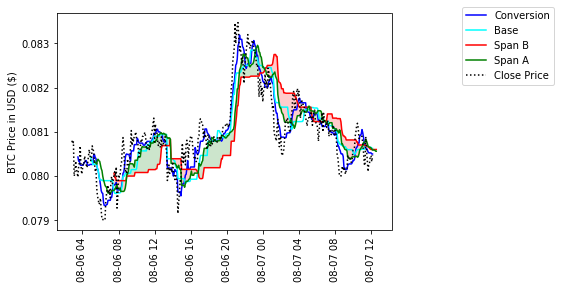

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='BTC Price in USD ($)')

column_names = list(ichimoku.columns)

colors = ['blue', 'cyan', 'red', 'green', 'magenta']
for col, color in zip(column_names, colors):
    if col != 'Lagging Close':
        ax1.plot(ichimoku.index, ichimoku[col], label=col, color=color)

ax1.plot(data.index, data.Close, linestyle=':', label="Close Price", color='k')

#fill the clouds

a = ichimoku['Span A']
b = ichimoku['Span B']

plt.fill_between(ichimoku.index, a, b, where=a >= b, facecolor='green', alpha='0.2', interpolate=True)
plt.fill_between(ichimoku.index, a, b, where=b >= a, facecolor='red', alpha='0.2', interpolate=True)

ax1.legend(bbox_to_anchor=(1.5, 1.05))
plt.xticks(rotation='vertical')
plt.show()

## Backtesting the Ichimoku Trading Strategy

In [241]:
signals = pd.DataFrame(index=ichimoku.index)
signals['signal'] = 0.0

t_more_than_k = ichimoku['Conversion'] > ichimoku['Base']
#green_cloud = ichimoku['Span A'] > ichimoku['Span B']
green_cloud = ichimoku['Span A']/ichimoku['Span B'] > 1.0025
t_above_green = np.logical_and((ichimoku['Conversion'] > ichimoku['Span A']), (ichimoku['Conversion'] > ichimoku['Span B']))

long_signals = np.where((np.logical_and(np.logical_and(t_more_than_k, green_cloud), t_above_green)), 1.0, 0.0)

#long_signals = np.where(np.logical_and(t_more_than_k, green_cloud), 1.0, 0.0)
#long_signals = np.where(green_cloud, 1.0, 0.0)
signals['buy'] = long_signals


signals['buy not true anymore'] = signals.buy.diff()

adjusted_long_hold = np.where((signals.buy.diff() > 0.0), 1.0, 0.0)
signals['hold'] = adjusted_long_hold

#short_signals = np.where(np.logical_and(np.logical_and(ichimoku['Conversion'] < ichimoku['Base'], ichimoku['Span A'] < ichimoku['Span B']), , 0.0, 1.0)
short_options = (signals['buy'].loc[(signals['buy'] == 0.0) & (signals['buy not true anymore'] == -1.0)]).index
#short_signals = np.where()
#signals['positions'] = signals['signal'].diff()

signals['sell'] = 0.0
signals.set_value(short_options, 'sell', -1.0)
signals['positions'] = signals.buy.diff()
signals['positions'].loc[signals.positions == 1.0]






2017-08-06 09:10:00    1.0
2017-08-06 16:55:00    1.0
2017-08-06 18:45:00    1.0
2017-08-06 19:40:00    1.0
2017-08-06 22:30:00    1.0
2017-08-06 22:50:00    1.0
Name: positions, dtype: float64

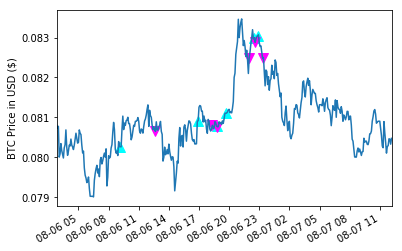

In [242]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='BTC Price in USD ($)')

#Plot the buy signals
ax1.plot(data.loc[signals['positions'] == 1.0].index, data['Close'][signals['positions'] == 1.0], '^', markersize=10, color='cyan')

#Plot the sell signals
ax1.plot(signals.loc[signals['positions'] == -1.0].index, data['Close'][signals['sell'] == -1.0], 'v', markersize=10, color='magenta')

data['Close'].plot(ax=ax1)
plt.show()

In [243]:
initial_shares = float(1000.0)

positions = pd.DataFrame(index=data.index).fillna(0.0)
positions["shares"] = 1000*signals['hold']

In [244]:
#portfolio = positions.multiply(data['Close'], axis=0)
#diff_positions = positions.diff()
#portfolio
#portfolio['holdings'] = (positions.multiply(data['Close'], axis=0)).sum(axis=1)
#portfolio['cash'] = initial_capital - (diff_positions.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()
#portfolio['total'] = portfolio['cash'] + portfolio['holdings']
#portfolio['returns'] = portfolio['total'].pct_change()
#diff_positions


portfolio = pd.DataFrame(index=positions.index)
portfolio['shares'] = positions['shares']
print positions.loc[positions['shares'] > 0]
portfolio['buy share price'] = 0.0
buy_indices = list(portfolio[(portfolio['shares'] > 0)].index)
print buy_indices
portfolio.ix[buy_indices, 'buy share price'] = data.Close.loc[buy_indices].values
signals.head()

                     shares
2017-08-06 09:10:00  1000.0
2017-08-06 16:55:00  1000.0
2017-08-06 18:45:00  1000.0
2017-08-06 19:40:00  1000.0
2017-08-06 22:30:00  1000.0
2017-08-06 22:50:00  1000.0
[Timestamp('2017-08-06 09:10:00'), Timestamp('2017-08-06 16:55:00'), Timestamp('2017-08-06 18:45:00'), Timestamp('2017-08-06 19:40:00'), Timestamp('2017-08-06 22:30:00'), Timestamp('2017-08-06 22:50:00')]


/Users/Kristen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,signal,buy,buy not true anymore,hold,sell,positions
2017-08-06 02:50:00,0.0,0.0,NaN,0.0,0.0,NaN
2017-08-06 02:55:00,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-06 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-06 03:05:00,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-06 03:10:00,0.0,0.0,0.0,0.0,0.0,0.0


In [245]:
portfolio['sell share price'] = 0.0

sell_indices = list(signals.loc[signals.positions == -1].index.shift(-5, freq='min'))
portfolio.ix[sell_indices, 'sell share price'] = data.Close.loc[sell_indices].values

portfolio['shares sold'] = 0.0
bought = portfolio['shares'].loc[portfolio['shares'] > 0.0].values
bought_price = portfolio['buy share price'].loc[portfolio['buy share price'] > 0.0].values
print bought_price
sold = portfolio['sell share price'].loc[portfolio['sell share price'] > 0.0].values
print sold

test = np.divide(sold, bought_price)

print test

portfolio.ix[sell_indices, 'shares sold'] = test
number_shares = 1000*test - 1000
total = sum(number_shares)
print ((total+1000)/1000)

[ 0.08025967  0.0809122   0.08077998  0.08110268  0.083       0.08304819]
[ 0.08068778  0.08071811  0.08077998  0.0821      0.083       0.08262532]
[ 1.00533406  0.99760123  1.          1.012297    1.          0.99490814]
1.01014042963


In [195]:
green_cloud = ichimoku['Span A'] > ichimoku['Span B']
print green_cloud.tail(-15)

2017-08-06 04:05:00    False
2017-08-06 04:10:00    False
2017-08-06 04:15:00    False
2017-08-06 04:20:00    False
2017-08-06 04:25:00    False
2017-08-06 04:30:00    False
2017-08-06 04:35:00    False
2017-08-06 04:40:00    False
2017-08-06 04:45:00    False
2017-08-06 04:50:00    False
2017-08-06 04:55:00    False
2017-08-06 05:00:00    False
2017-08-06 05:05:00    False
2017-08-06 05:10:00    False
2017-08-06 05:15:00    False
2017-08-06 05:20:00    False
2017-08-06 05:25:00    False
2017-08-06 05:30:00    False
2017-08-06 05:35:00    False
2017-08-06 05:40:00    False
2017-08-06 05:45:00    False
2017-08-06 05:50:00    False
2017-08-06 05:55:00    False
2017-08-06 06:00:00    False
2017-08-06 06:05:00    False
2017-08-06 06:10:00    False
2017-08-06 06:15:00    False
2017-08-06 06:20:00    False
2017-08-06 06:25:00    False
2017-08-06 06:30:00    False
                       ...  
2017-08-07 10:10:00    False
2017-08-07 10:15:00    False
2017-08-07 10:20:00    False
2017-08-07 10:

In [196]:
shifted_green_cloud = ichimoku['Span A'].shift(-10) > ichimoku['Span B'].shift(-10)
print shifted_green_cloud.tail(-15)

2017-08-06 04:05:00    False
2017-08-06 04:10:00    False
2017-08-06 04:15:00    False
2017-08-06 04:20:00    False
2017-08-06 04:25:00    False
2017-08-06 04:30:00    False
2017-08-06 04:35:00    False
2017-08-06 04:40:00    False
2017-08-06 04:45:00    False
2017-08-06 04:50:00    False
2017-08-06 04:55:00    False
2017-08-06 05:00:00    False
2017-08-06 05:05:00    False
2017-08-06 05:10:00    False
2017-08-06 05:15:00    False
2017-08-06 05:20:00    False
2017-08-06 05:25:00    False
2017-08-06 05:30:00    False
2017-08-06 05:35:00    False
2017-08-06 05:40:00    False
2017-08-06 05:45:00    False
2017-08-06 05:50:00    False
2017-08-06 05:55:00    False
2017-08-06 06:00:00    False
2017-08-06 06:05:00    False
2017-08-06 06:10:00    False
2017-08-06 06:15:00    False
2017-08-06 06:20:00    False
2017-08-06 06:25:00    False
2017-08-06 06:30:00    False
                       ...  
2017-08-07 10:10:00    False
2017-08-07 10:15:00    False
2017-08-07 10:20:00     True
2017-08-07 10: